# Struqture Hamiltonians

In this guide you will learn how to create operators using
[Struqture](https://github.com/HQSquantumsimulations/struqture), which
is a library
that is used to describe quantum mechanical operators and systems. It can
be used as an input to HQS Quantum Solver for defining spin systems.

For this chapter, we use the system of antiferromagnetically coupled
spins defined by the Hamiltonian $\hat{H}$, where

$$
  \hat{H} = J \sum_{j = 0}^{M-2} \hat{\mathbf{S}}_j \cdot
    \hat{\mathbf{S}}_{j+1}
  \, \quad\text{and}\quad
  J > 0,
$$
as an example.

## Imports & Parameters

Throughout this chapter, we will use the following imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from struqture_py import PauliHamiltonian

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, magnetic_field_z, struqture_term
)

# License check turned off for lattice_functions.
# License check turned off for lattice_solver.


Furthermore, we will make use of the following parameters.

In [2]:
M = 8    # number of sites/spins
J = 1.0  # interaction strength
B = 3.0  # magnetic field strength (will be introduced later)

## Building Operators

Hamiltonians for spin systems can be described in Struqture using the
[PauliHamiltonian] class. (Other options for describing spin systems are
the [PauliOperator] and [PlusMinusOperator] classes.)
The class describes a sum of products of operators.
Each operator acts on a specific site of the system, and each product
has at most one operator per site.
More precisely, the operators have the form
$$
  \hat{A} =
    \sum_k \alpha_k \prod_{j = 0}^{M-1} \hat{B}_{kj}
    \quad\text{where}\quad
    \alpha_j \in \mathbb{C} \quad\text{and}\quad
    \hat{B}_{kj} \in \{
      \hat{I}, \hat{X}_j, \hat{Y}_j, \hat{Z}_j \}
  \,.
$$
Inhere,
$\hat{X}_j = 2 \hat{S}^x_j$, $\hat{Y}_j = 2 \hat{S}^y_j$, and
$\hat{Z}_j = 2 \hat{S}^z_j$.
The previously defined Hamiltonian can be written in this form: we have
that
$$
  \hat{H}
    = J \sum_{j = 0}^{M-2} (
      \hat{S}^x_j \hat{S}^x_{j+1} +
      \hat{S}^y_j \hat{S}^y_{j+1} +
      \hat{S}^z_j \hat{S}^z_{j+1}
    )
    =
    \tfrac{1}{4} J \sum_{j=0}^{M-2} (
      \hat{X}_j \hat{X}_{j+1} +
      \hat{Y}_j \hat{Y}_{j+1} +
      \hat{Z}_j \hat{Z}_{j+1}
    )\,,
$$
which has the desired shape.

To define the Hamiltonian using Struqture, we first create an object of type
[PauliHamiltonian] and then add the individual products using the
`.add_operator_product` method.
Each product is given by a string, describing the operator product, and the
corresponding coefficient.
The string consecutively lists the terms of the product,
where each factor is represented by a number followed by a character.
The number defines the site the operator is acting on, and the character
defines the type of the operator, e.g. `"2X3X"` describes the product
$\hat{X}_2 \hat{X}_3$.
In the following code, we use
[Python format strings](https://docs.python.org/3/library/string.html#formatstrings)
to build the required strings.

[PauliHamiltonian]: https://hqsquantumsimulations.github.io/struqture/python_api_docs/generated/struqture_py.html#struqture_py.PauliHamiltonian
[PauliOperator]: https://hqsquantumsimulations.github.io/struqture/python_api_docs/generated/struqture_py.html#struqture_py.PauliOperator
[PlusMinusOperator]: https://hqsquantumsimulations.github.io/struqture/python_api_docs/generated/struqture_py.html#struqture_py.PlusMinusOperator

In [3]:
interaction = PauliHamiltonian()

for j in range(M - 1):
    interaction.add_operator_product(f"{j}X{j+1}X", 0.25 * J)
    interaction.add_operator_product(f"{j}Y{j+1}Y", 0.25 * J)
    interaction.add_operator_product(f"{j}Z{j+1}Z", 0.25 * J)

print(interaction)

PauliHamiltonian{
0X1X: 2.5e-1,
0Y1Y: 2.5e-1,
0Z1Z: 2.5e-1,
1X2X: 2.5e-1,
1Y2Y: 2.5e-1,
1Z2Z: 2.5e-1,
2X3X: 2.5e-1,
2Y3Y: 2.5e-1,
2Z3Z: 2.5e-1,
3X4X: 2.5e-1,
3Y4Y: 2.5e-1,
3Z4Z: 2.5e-1,
4X5X: 2.5e-1,
4Y5Y: 2.5e-1,
4Z5Z: 2.5e-1,
5X6X: 2.5e-1,
5Y6Y: 2.5e-1,
5Z6Z: 2.5e-1,
6X7X: 2.5e-1,
6Y7Y: 2.5e-1,
6Z7Z: 2.5e-1,
}


Running the code above creates the desired operator and prints the following
output, which shows how Struqture stores the operator, where each line gives
one summand from the formula for the Hamiltonian.

```
PauliHamiltonian{
0X1X: 5e-1,
0Y1Y: 5e-1,
0Z1Z: 5e-1,
1X2X: 5e-1,
1Y2Y: 5e-1,
1Z2Z: 5e-1,
2X3X: 5e-1,
2Y3Y: 5e-1,
2Z3Z: 5e-1,
3X4X: 5e-1,
3Y4Y: 5e-1,
3Z4Z: 5e-1,
4X5X: 5e-1,
4Y5Y: 5e-1,
4Z5Z: 5e-1,
5X6X: 5e-1,
5Y6Y: 5e-1,
5Z6Z: 5e-1,
}
```

Having a description of the Hamiltonian, we can create an actual operator
that we can use in computations. The first thing to do is to convert the
Struqture object into a Quantum Solver expression, using the
[struqture_term](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.struqture_term) function.
Then, we need to create a [VectorSpace](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace)
object that described the vector space the operator is acting on, and
finally an
[Operator](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator)
object, by passing in the expression describing the operator and the vector
space. Note that we can use the `.current_number_spins` method to set
the number of sites in the vector space.

In [4]:
v = VectorSpace(sites=interaction.current_number_spins(), total_spin_z="all")
hamiltonian = Operator(struqture_term(interaction), domain=v)

With the operator, we can now compute and plot the energy levels.
Since Quantum Solver operators are compatible to SciPy, we can directly
call the [eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) function from SciPy to
obtain the energy levels. Then we use Matplotlib to create a plot of the
levels.

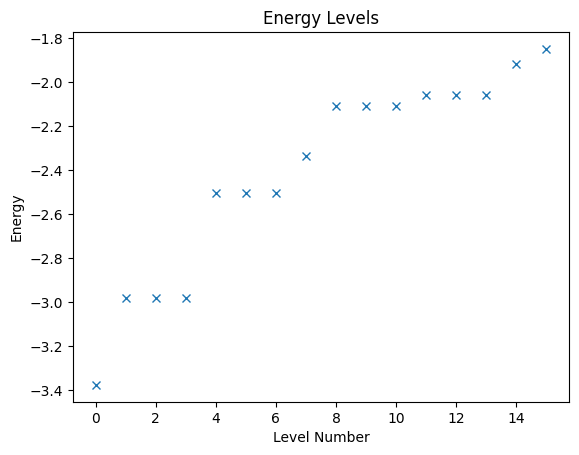

In [5]:
eigvals, eigvecs = eigsh(hamiltonian, k=16, which="SA")

plt.figure("energy")
plt.title("Energy Levels")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals, "x")

## Restricting the Spin Polarization

If we know that we only need to consider states with a given
total spin polarization in $z$ direction, e.g., when considering
Hamiltonians that conserve the total spin polarization, we can
restrict the states the vector space represents accordingly.
This restriction can significantly reduce the amount of computational work
needed. Say, we know that the total spin polarization is zero. Then,
we can create the restricted vector space and the operator that is
defined on it as follows.

In [6]:
w = VectorSpace(sites=interaction.current_number_spins(), total_spin_z=0)
hamiltonian2 = Operator(struqture_term(interaction), domain=w)

Computing and plotting the energy levels can then be done as before.

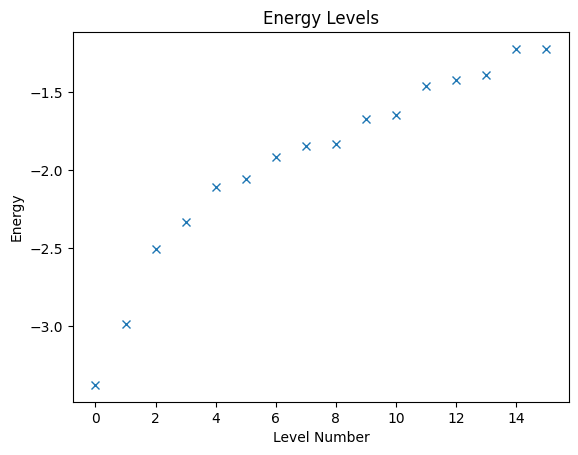

In [7]:
eigvals2, eigvecs2 = eigsh(hamiltonian2, k=16, which="SA")

plt.figure("energy-restricted")
plt.title("Energy Levels")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals2, "x")

## Combining Expressions

Next, we want to consider a slightly more complicated example.
Assume that the spin system that we have defined at the beginning of
this chapter is exposed to a magnetic field in direction of the $z$-axis.
More precisely, we want to consider the Hamiltonian that is given by

$$
  \hat{H} =
    - B \sum_{J = 0}^{M-1} \hat{S}^z_j
    + J \sum_{j = 0}^{M-2} \hat{\mathbf{S}}_j \cdot
      \hat{\mathbf{S}}_{j+1}
  \,.
$$

If we wanted, we could build the entire Hamiltonian using Struqture.
There is, however, an easier way. Quantum Solver has already a definition
of the magnetic-field term, namely the
[magnetic_field_z](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.magnetic_field_z) function.
Furthermore, Quantum Solver allows building of arbitrary linear combination
of Quantum Solver expressions. Hence, we can combine the
Struqture definition of the spin interaction with the
[magnetic_field_z](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.magnetic_field_z) function,
which is shown below.

In [8]:
hamiltonian3 = Operator(
    magnetic_field_z(coef=B * np.ones(v.sites)) + struqture_term(interaction),
    domain=w
)

Then, again, we can compute the energy levels and plot them.

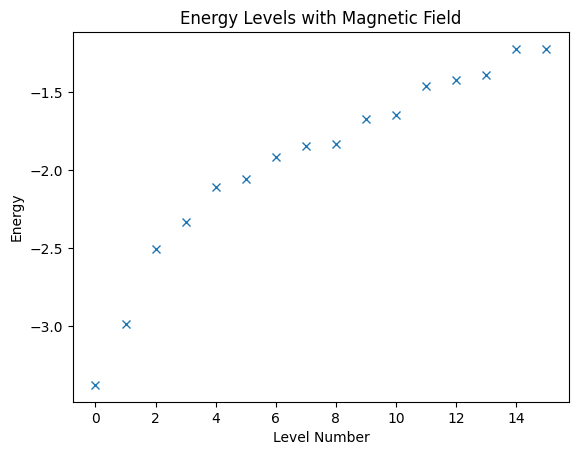

In [9]:
eigvals3, eigvecs3 = eigsh(hamiltonian3, k=16, which="SA")

plt.figure("energy-with-field")
plt.title("Energy Levels with Magnetic Field")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals3, "x")

plt.show()

## Complete Code

```python
# Title    : Using Struqture with HQS Quantum Solver
# Filename : struqture.py

# ===== Imports and Parameters =====

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

from struqture_py import PauliHamiltonian

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, magnetic_field_z, struqture_term
)

M = 8    # number of sites/spins
J = 1.0  # interaction strength
B = 3.0  # magnetic field strength (will be introduced later)

# ===== Struqture Definition of the System =====

interaction = PauliHamiltonian()

for j in range(M - 1):
    interaction.add_operator_product(f"{j}X{j+1}X", 0.25 * J)
    interaction.add_operator_product(f"{j}Y{j+1}Y", 0.25 * J)
    interaction.add_operator_product(f"{j}Z{j+1}Z", 0.25 * J)

print(interaction)

# ===== Creating the Operator =====

v = VectorSpace(sites=interaction.current_number_spins(), total_spin_z="all")
hamiltonian = Operator(struqture_term(interaction), domain=v)

eigvals, eigvecs = eigsh(hamiltonian, k=16, which="SA")

plt.figure("energy")
plt.title("Energy Levels")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals, "x")

# ===== Restricted Sz =====

w = VectorSpace(sites=interaction.current_number_spins(), total_spin_z=0)
hamiltonian2 = Operator(struqture_term(interaction), domain=w)

eigvals2, eigvecs2 = eigsh(hamiltonian2, k=16, which="SA")

plt.figure("energy-restricted")
plt.title("Energy Levels")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals2, "x")

# ===== Combining Expressions =====

hamiltonian3 = Operator(
    magnetic_field_z(coef=B * np.ones(v.sites)) + struqture_term(interaction),
    domain=w
)

eigvals3, eigvecs3 = eigsh(hamiltonian3, k=16, which="SA")

plt.figure("energy-with-field")
plt.title("Energy Levels with Magnetic Field")
plt.xlabel("Level Number")
plt.ylabel("Energy")
plt.plot(eigvals3, "x")

plt.show()
```